# Cycling in numbers - A Case Study of Cycle Paths in Rhine-Kreis Neuss

## Description

Five Counting stations have been permanently documenting cycling traffic on central roads since 2016 in Cycle paths in the Rhine-Kreis Neuss. The daily measurement of cycling traffic is done with the help of induction loops laid in the ground. With the permanent collection of data can gain insights on the daily, weekly and annual cycles and on it building long-term cycling developments over several years.

More details on the data source here: https://data.europa.eu/data/datasets/eco-counter-data-rhein-kreis-neuss?locale=en


# Stage 2: Data Analysis and Future Trend Predictions

The purpose of this notebook is to gain insights on the daily, weekly and annual trends and predict cycling traffic for the next 6 months. 

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service


**Requirements:**

1. Hadoop should be running.
2. Stage 1 of this process should have been completed and data from that stage saved to hadoop.
3. Dataset should be in this directory in hadoop: [hdfs://localhost:9000//g10_datalake/silver/cycling/](hdfs://localhost:9000//g10_datalake/silver/cycling/)


<a id='1.2'></a>
### 1.1 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()


Changing pandas max column width property to improve data displaying.

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession


In [3]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("group_10_analysis")
    .getOrCreate())

spark.sparkContext.setLogLevel("ERROR")

25/03/17 21:23:28 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
25/03/17 21:23:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/17 21:23:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<a id='2'></a>
## 2. A Closer Look at the Data

**Reading the data from hadoop**

In [4]:
df = (spark.read.option("header", "true")
                 .option("inferSchema", "true")
                 .csv("hdfs://localhost:9000//g10_datalake/silver/cycling/cleaned_cycling_data")
                 .cache())

df.show(5)

+---------+-------------------+-----+------+----------+----------------+-------------------+----+-----+---+----+-----------+---------+---------+
|       Id|               Date|Count|Status|Channel_Id|Counting_Station|        Coordinates|Year|Month|Day|Hour|Day_of_Week| Latitude|Longitude|
+---------+-------------------+-----+------+----------+----------------+-------------------+----+-----+---+----+-----------+---------+---------+
|100019715|2021-10-09 10:00:00|   17|   raw| 101019715|       Meerbusch|51.261012, 6.705018|2021|   10|  9|  10|          7|51.261012| 6.705018|
|100019715|2021-10-09 12:00:00|   46|   raw| 101019715|       Meerbusch|51.261012, 6.705018|2021|   10|  9|  12|          7|51.261012| 6.705018|
|100019715|2021-10-09 15:00:00|  108|   raw| 101019715|       Meerbusch|51.261012, 6.705018|2021|   10|  9|  15|          7|51.261012| 6.705018|
|100019715|2021-10-09 17:00:00|   65|   raw| 101019715|       Meerbusch|51.261012, 6.705018|2021|   10|  9|  17|          7|51.261

In [5]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Channel_Id: integer (nullable = true)
 |-- Counting_Station: string (nullable = true)
 |-- Coordinates: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



**Importing the libraries required for our analysis**

In [6]:
from pyspark.sql.functions import col, avg, to_date, sum as _sum, when
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

from pyspark.sql import functions as F
import folium


Importing plotly failed. Interactive plots will not work.


### 2.1 Let's look at where the counting stations are

In [7]:
# Ensure Latitude and Longitude columns are not null
df_coordinates_clean = df.filter(F.col("Latitude").isNotNull() & F.col("Longitude").isNotNull())

# Get distinct pairs of Latitude and Longitude
distinct_coordinates = df_coordinates_clean.select("Latitude", "Longitude").distinct()

# Convert to Pandas DataFrame for easier manipulation (if needed)
distinct_coordinates_pandas = distinct_coordinates.toPandas()

# Calculate the average Latitude and Longitude
average_lat = distinct_coordinates_pandas["Latitude"].mean()
average_lon = distinct_coordinates_pandas["Longitude"].mean()

# Create a Folium map centered on the average Latitude and Longitude
import folium

m = folium.Map(location=[average_lat, average_lon], zoom_start=11, width="100%", height="100%")

# Add markers for each distinct coordinate
for index, row in distinct_coordinates_pandas.iterrows():
    folium.Marker(
        [row['Latitude'], row['Longitude']], 
        popup=f"Latitude: {row['Latitude']}, Longitude: {row['Longitude']}",
        icon=folium.Icon(color="blue", icon="info-sign")  
    ).add_to(m)

# Display the map
m

# Save the map as an HTML file
m.save('distinct_coordinates_map.html')


### 2.2 Time series plots from each station

Text(0.5, 1.0, 'Station: Neuss')

Text(0.5, 500.7222222222223, 'Date')

Text(150.22222222222223, 0.5, 'Count')

Text(0.5, 1.0, 'Station: Meerbusch')

Text(0.5, 500.7222222222223, 'Date')

Text(560.5163398692812, 0.5, 'Count')

Text(0.5, 1.0, 'Station: Dormagen')

Text(0.5, 500.7222222222223, 'Date')

Text(970.81045751634, 0.5, 'Count')

Text(0.5, 1.0, 'Station: Jüchen')

Text(0.5, 80.7222222222222, 'Date')

Text(150.22222222222223, 0.5, 'Count')

Text(0.5, 1.0, 'Station: Grevenbroich')

Text(0.5, 80.7222222222222, 'Date')

Text(560.5163398692812, 0.5, 'Count')

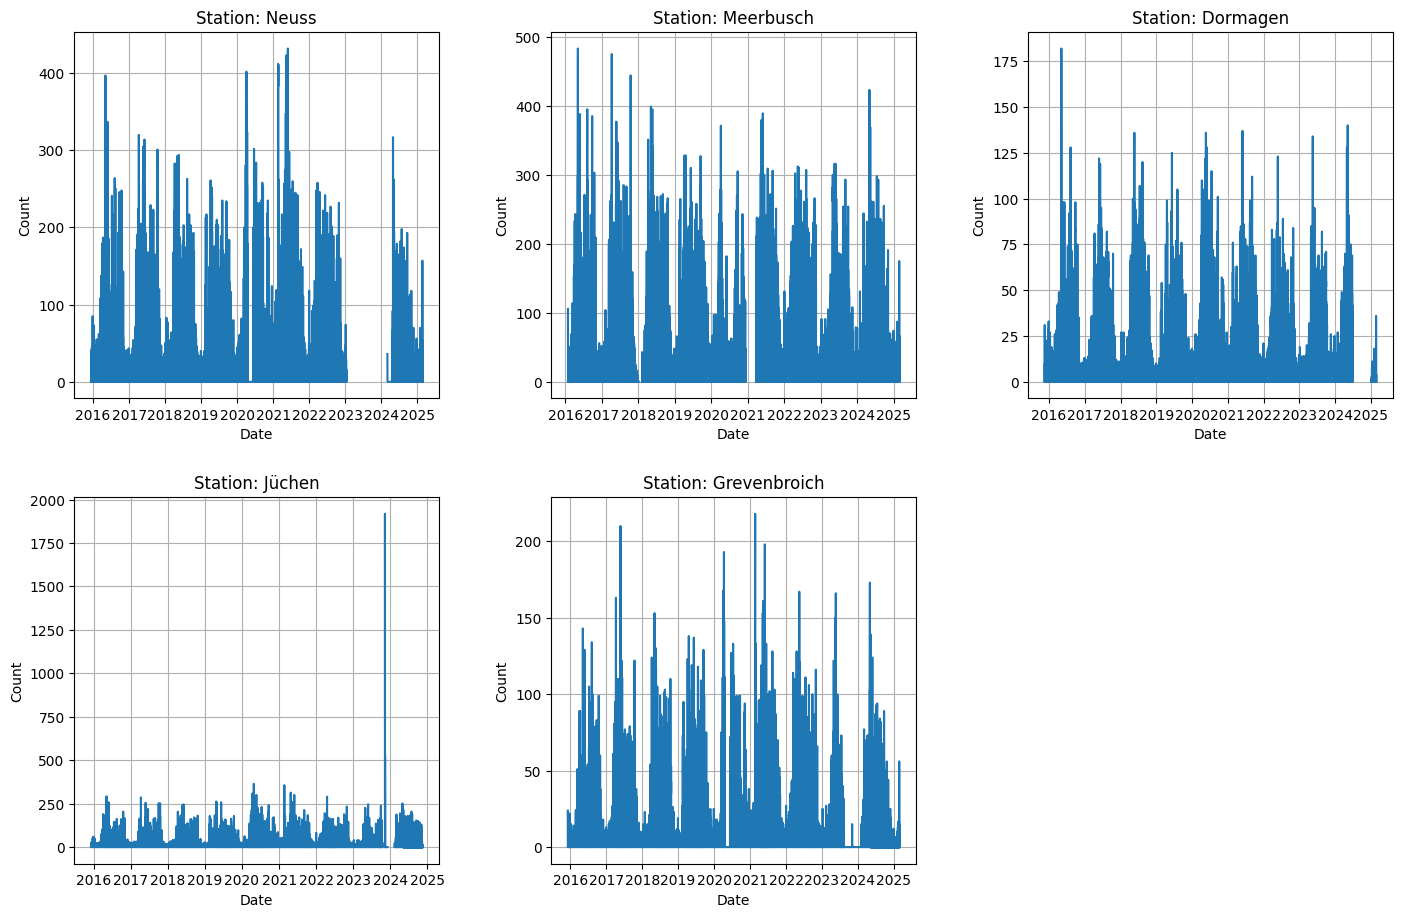

In [8]:
# Collect unique Counting Stations
stations = df.select("Counting_Station").distinct().collect()

# Set up the grid layout: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=5.0)  
axes = axes.flatten()  

# Loop through each station
for idx, station_row in enumerate(stations):
    if idx >= len(axes):  
        break

    station = station_row["Counting_Station"]
    
    # Filter the DataFrame for each Counting Station
    station_df = df.filter(col("Counting_Station") == station)
    
    # Group by Date and sum Count
    grouped_station_df = (
        station_df.groupBy("Year", "Month", "Day", "Hour")
        .sum("Count")
        .withColumnRenamed("sum(Count)", "TotalCount")
        .orderBy("Year", "Month", "Day", "Hour")
    )

    # Convert to Pandas for plotting
    pandas_df = grouped_station_df.toPandas()

    # Create a proper datetime index for plotting
    pandas_df['DateTime'] = pd.to_datetime(
        pandas_df[['Year', 'Month', 'Day', 'Hour']]
    )
    pandas_df.set_index('DateTime', inplace=True)

    # Plot each station's data on a separate subplot
    axes[idx].plot(pandas_df.index, pandas_df["TotalCount"], label=f"{station}")
    axes[idx].set_title(f'Station: {station}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(True)

# Remove unused subplots as there are fewer than 6 stations
for i in range(len(stations), len(axes)):
    fig.delaxes(axes[i]) 

plt.show()


### 2.3 Hourly average to check for trend

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Overall Hourly Average Bicycle Count')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Average Bicycle Count')

([<matplotlib.axis.XTick at 0x7fc20744e350>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

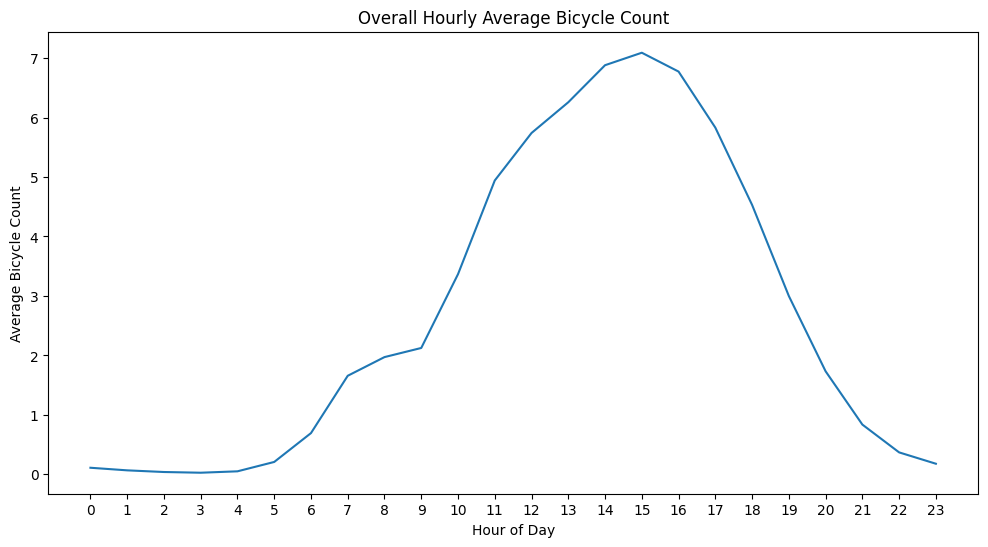

In [9]:
# Group by Hour and compute the average Count across all stations
hourly_avg_df = (
    df.groupBy("Hour")
    .agg(F.avg("Count").alias("AvgCount"))
    .orderBy("Hour")
)

# Convert to Pandas for plotting
pandas_df = hourly_avg_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(pandas_df["Hour"], pandas_df["AvgCount"])
plt.title("Overall Hourly Average Bicycle Count")
plt.xlabel("Hour of Day")
plt.ylabel("Average Bicycle Count")
plt.xticks(range(0, 24)) 

plt.show()


### 2.4 Daily averages to check for trend

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Station: Neuss')

Text(187.72222222222223, 0.5, 'Total Count')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Station: Meerbusch')

Text(680.0751633986929, 0.5, 'Total Count')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Station: Dormagen')

Text(1172.4281045751634, 0.5, 'Total Count')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Station: Jüchen')

Text(187.72222222222223, 0.5, 'Total Count')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Station: Grevenbroich')

Text(680.0751633986929, 0.5, 'Total Count')

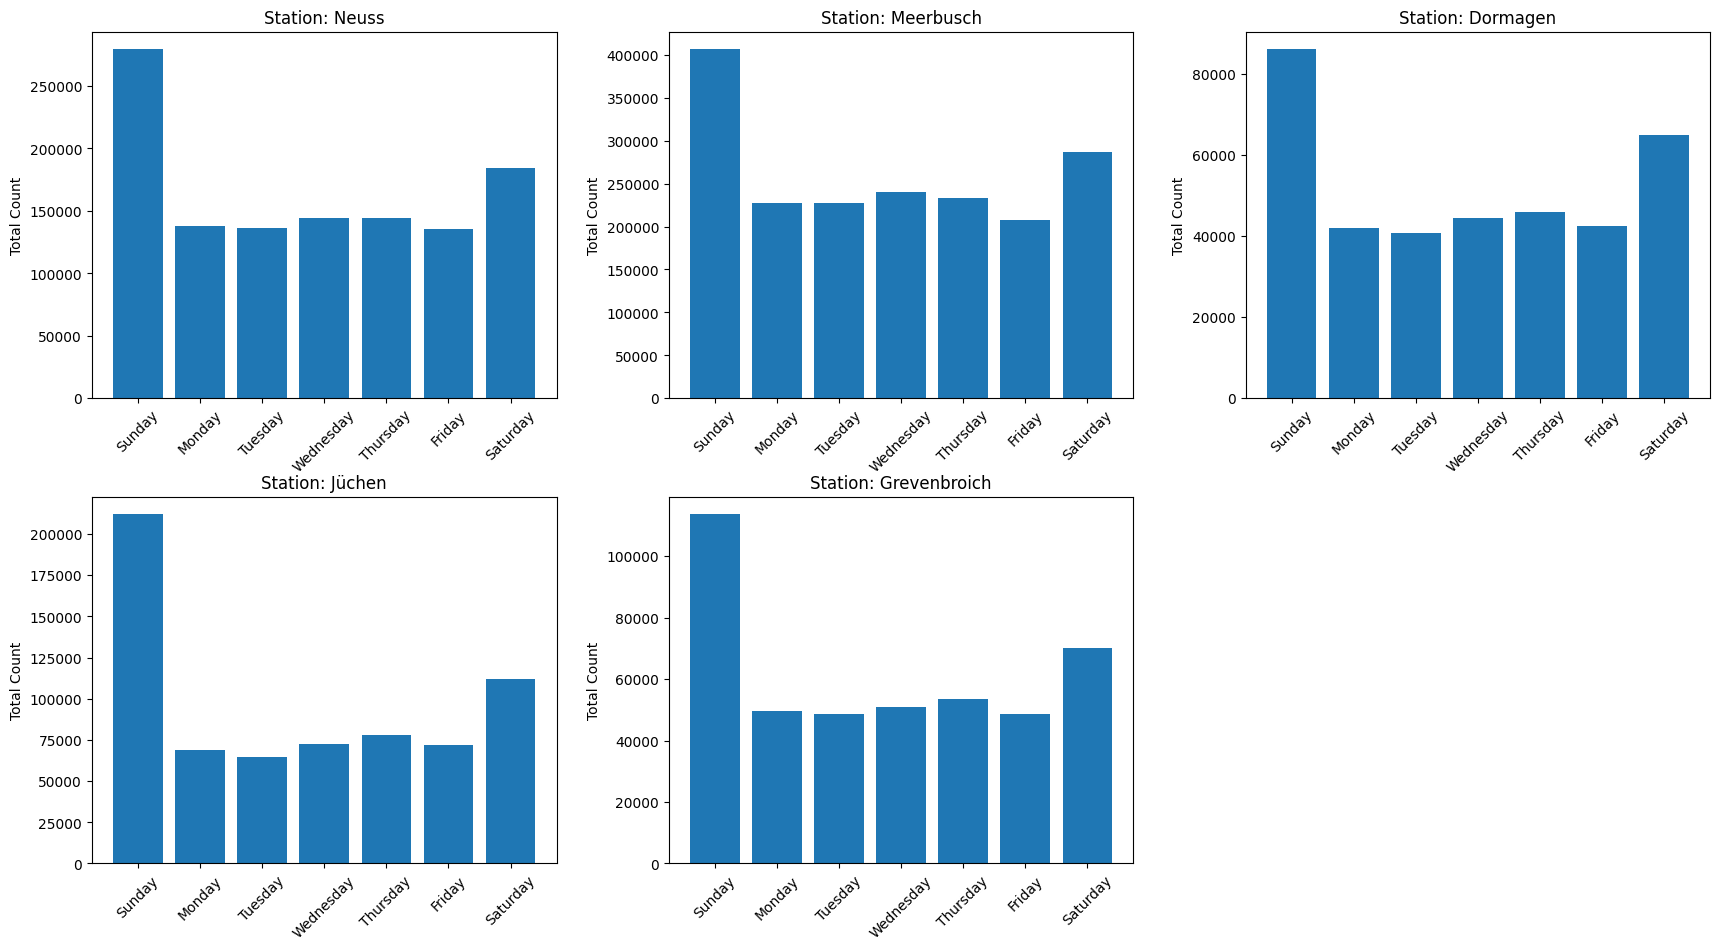

In [10]:
# Set up the grid dimensions: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) 
fig.tight_layout(pad=5.0)
axes = axes.flatten()

# Weekday mapping with 1 = Sunday and 7 = Saturday
day_labels = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 
              5: "Thursday", 6: "Friday", 7: "Saturday"}

# Loop through each Counting_Station
for idx, station_row in enumerate(stations):
    station = station_row["Counting_Station"]
    
    # Filter for specific Counting_Station and group by Day_of_Week
    station_df = df.filter(col("Counting_Station") == station)

    grouped_station_df = (
        station_df.groupBy("Day_of_Week")
        .agg(F.sum("Count").alias("TotalCount")) 
        .orderBy("Day_of_Week")
    )

    # Convert to Pandas for plotting
    pandas_df = grouped_station_df.toPandas()

    # Replace numeric days with weekday names
    pandas_df["Day_of_Week"] = pandas_df["Day_of_Week"].map(day_labels)

    # Plot for the specific Counting_Station
    axes[idx].bar(pandas_df["Day_of_Week"], pandas_df["TotalCount"])
    axes[idx].set_title(f"Station: {station}")
    axes[idx].set_ylabel("Total Count")
    axes[idx].tick_params(axis="x", rotation=45)  

# Remove extra subplot since there are only 5 stations
for i in range(len(stations), len(axes)):
    fig.delaxes(axes[i])  

plt.show()


### 2.5 Monthly Total to check for trend

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'Station: Neuss')

Text(187.72222222222223, 0.5, 'Total Count')

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'Station: Meerbusch')

Text(680.0751633986929, 0.5, 'Total Count')

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'Station: Dormagen')

Text(1172.4281045751634, 0.5, 'Total Count')

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'Station: Jüchen')

Text(187.72222222222223, 0.5, 'Total Count')

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'Station: Grevenbroich')

Text(680.0751633986929, 0.5, 'Total Count')

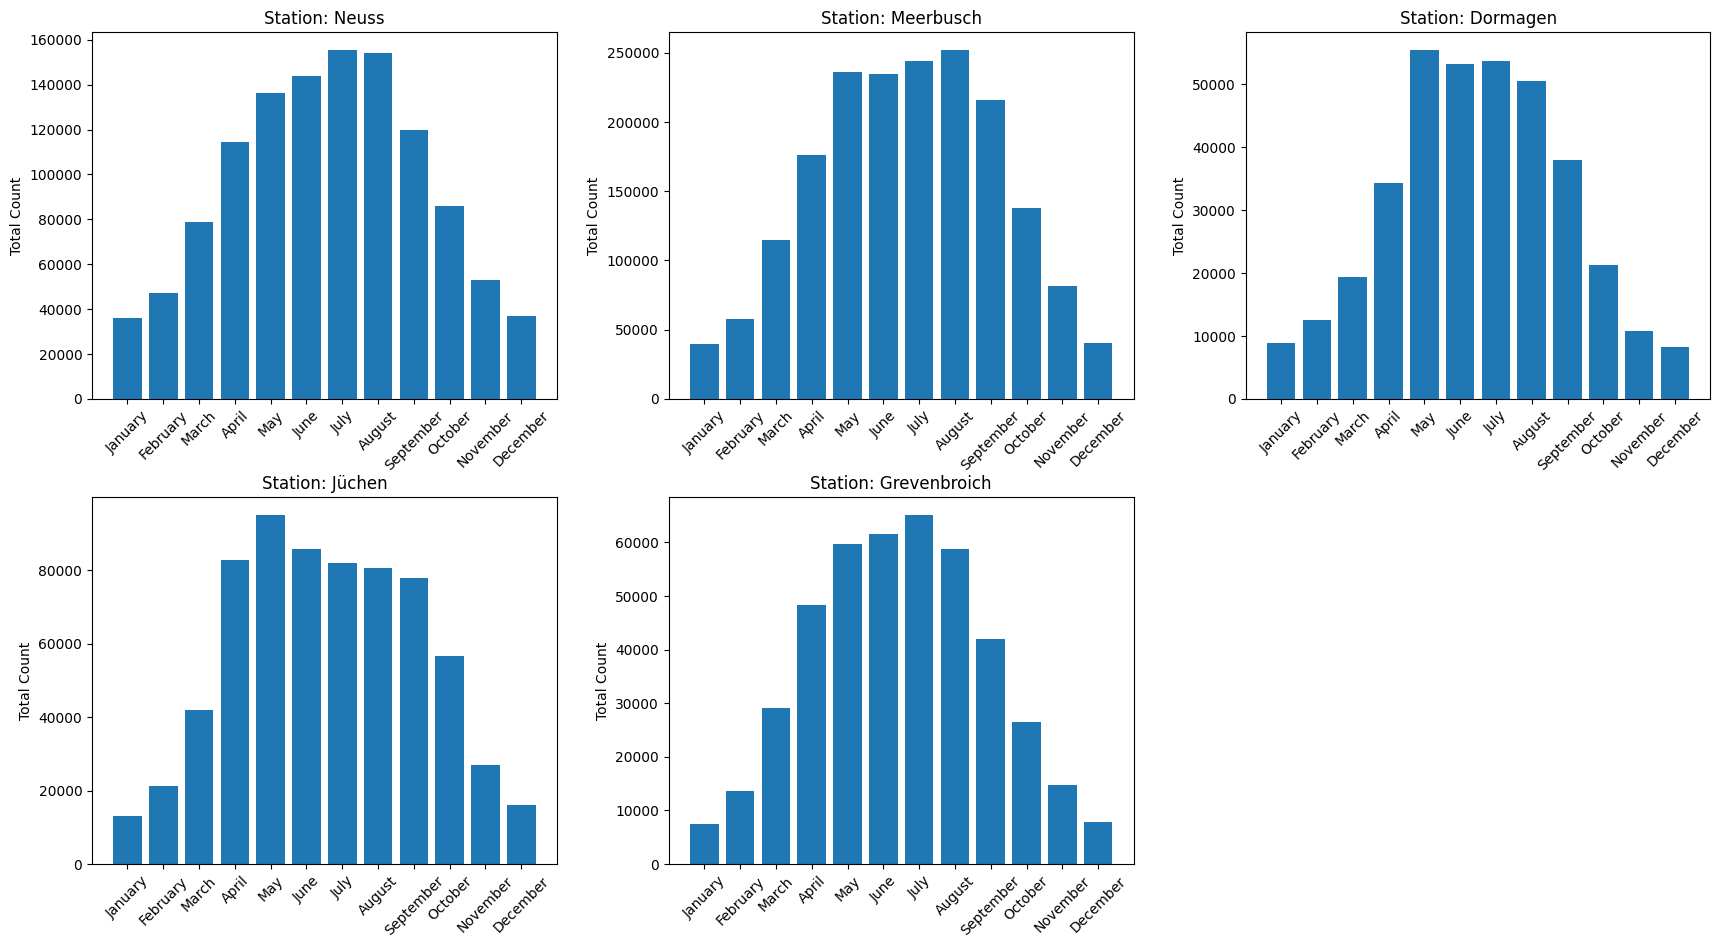

In [11]:
# Set up the grid dimensions: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
fig.tight_layout(pad=5.0)
axes = axes.flatten() 

# Month mapping for better readability
month_labels = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# Loop through each Counting_Station
for idx, station_row in enumerate(stations):
    station = station_row["Counting_Station"]
    
    # Filter for specific Counting_Station and group by Month
    station_df = df.filter(col("Counting_Station") == station)
    grouped_station_df = (
        station_df.groupBy("Month")
        .agg(F.sum("Count").alias("TotalCount")) 
        .orderBy("Month")
    )

    # Convert to Pandas for plotting
    pandas_df = grouped_station_df.toPandas()

    # Replace numeric months with month names
    pandas_df["Month"] = pandas_df["Month"].map(month_labels)

    # Plot for the specific Counting_Station
    axes[idx].bar(pandas_df["Month"], pandas_df["TotalCount"])
    axes[idx].set_title(f"Station: {station}")
    axes[idx].set_ylabel("Total Count")  
    axes[idx].tick_params(axis="x", rotation=45)  

# Remove extra subplot since there are only 5 stations
for i in range(len(stations), len(axes)):
    fig.delaxes(axes[i]) 

plt.show()


### 2.6 Focus on Meersbusch - Predicting future cycling numbers for planning

In [12]:
# Filter the data for Counting_Station == "Meerbusch"
df_meerbusch = df.filter(df.Counting_Station == "Meerbusch")

# Order the filtered DataFrame by the Date column
df_meerbusch_ordered = df_meerbusch.orderBy("Date")

# Display the first 5 rows
df_meerbusch_ordered.show(5)


+---------+-------------------+-----+------+----------+----------------+-------------------+----+-----+---+----+-----------+---------+---------+
|       Id|               Date|Count|Status|Channel_Id|Counting_Station|        Coordinates|Year|Month|Day|Hour|Day_of_Week| Latitude|Longitude|
+---------+-------------------+-----+------+----------+----------------+-------------------+----+-----+---+----+-----------+---------+---------+
|100019715|2016-01-26 00:00:00|    0|   raw| 102019715|       Meerbusch|51.261012, 6.705018|2016|    1| 26|   0|          3|51.261012| 6.705018|
|100019715|2016-01-26 00:00:00|    0|   raw| 103019715|       Meerbusch|51.261012, 6.705018|2016|    1| 26|   0|          3|51.261012| 6.705018|
|100019715|2016-01-26 00:00:00|    0|   raw| 101019715|       Meerbusch|51.261012, 6.705018|2016|    1| 26|   0|          3|51.261012| 6.705018|
|100019715|2016-01-26 00:00:00|    0|   raw| 104019715|       Meerbusch|51.261012, 6.705018|2016|    1| 26|   0|          3|51.261

In [13]:
df_meerbusch.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Channel_Id: integer (nullable = true)
 |-- Counting_Station: string (nullable = true)
 |-- Coordinates: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



#### 2.6.1 Six Month Prediction based on aggregated daily count

21:26:02 - cmdstanpy - INFO - Chain [1] start processing                        
21:26:03 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Out-of-Sample Forecast for Meerbusch (Next 180 Days) with daily averages')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Count')

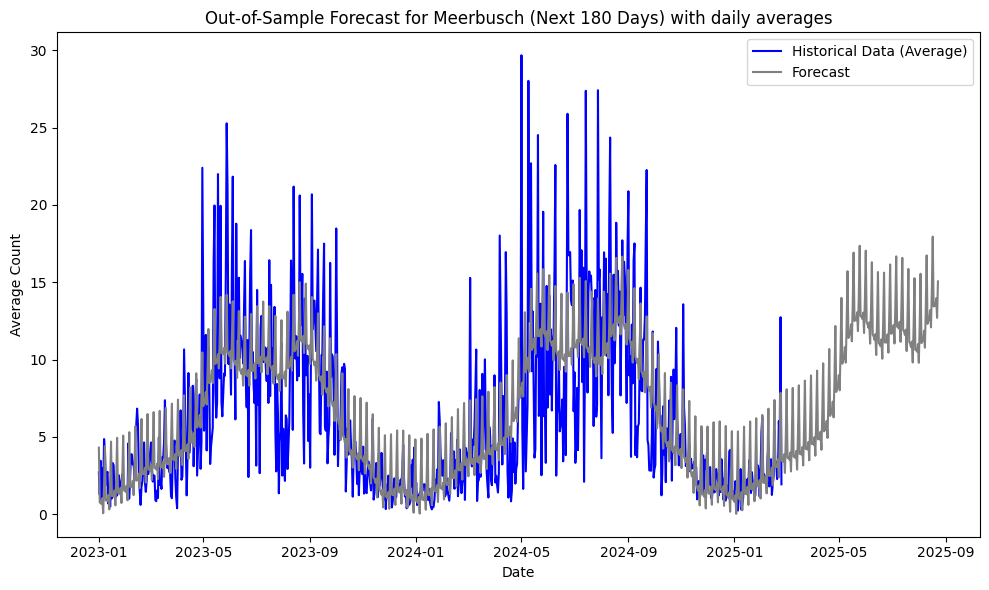

In [14]:
# Filter data for 2023 onwards and correct negative counts
df_meerbusch_filtered = (
    df_meerbusch.filter(col("Date") >= "2023-01-01")
    .withColumn("Count", when(col("Count") < 0, 0).otherwise(col("Count")))
)

# Aggregate hourly data by day (use average instead of sum)
aggregated_meerbusch_df = (
    df_meerbusch_filtered.withColumn("Date", to_date(col("Date"))) 
    .groupBy("Date")
    .agg(avg("Count").alias("aggregated_count"))  
    .filter(col("aggregated_count") >= 0)  
    .orderBy("Date")
)

# Prepare data for Prophet
prophet_data = aggregated_meerbusch_df.select(
    col("Date").alias("ds"), col("aggregated_count").alias("y")
).orderBy("ds")

# Convert to Pandas
prophet_data_pandas = prophet_data.toPandas()
prophet_data_pandas["ds"] = pd.to_datetime(prophet_data_pandas["ds"])
prophet_data_pandas["y"] = pd.to_numeric(prophet_data_pandas["y"]).fillna(0)

# Train Prophet model with no negatives in the data
model = Prophet(seasonality_mode="multiplicative") 
model.fit(prophet_data_pandas)

# Forecast future values (ensure no negative values in the forecast)
future = model.make_future_dataframe(periods=180, freq="D", include_history=True)
forecast = model.predict(future)
forecast["yhat"] = forecast["yhat"].clip(lower=0)  

# Plot future forecast
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(prophet_data_pandas["ds"], prophet_data_pandas["y"], label="Historical Data (Average)", color="blue")

# Plot forecast
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="gray")

# Add labels, title, and grid
plt.title("Out-of-Sample Forecast for Meerbusch (Next 180 Days) with daily averages")
plt.xlabel("Date")
plt.ylabel("Average Count")
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Zoomed-in Out-of-Sample Forecast for Meerbusch (Next 180 Days) with daily averages')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Count')

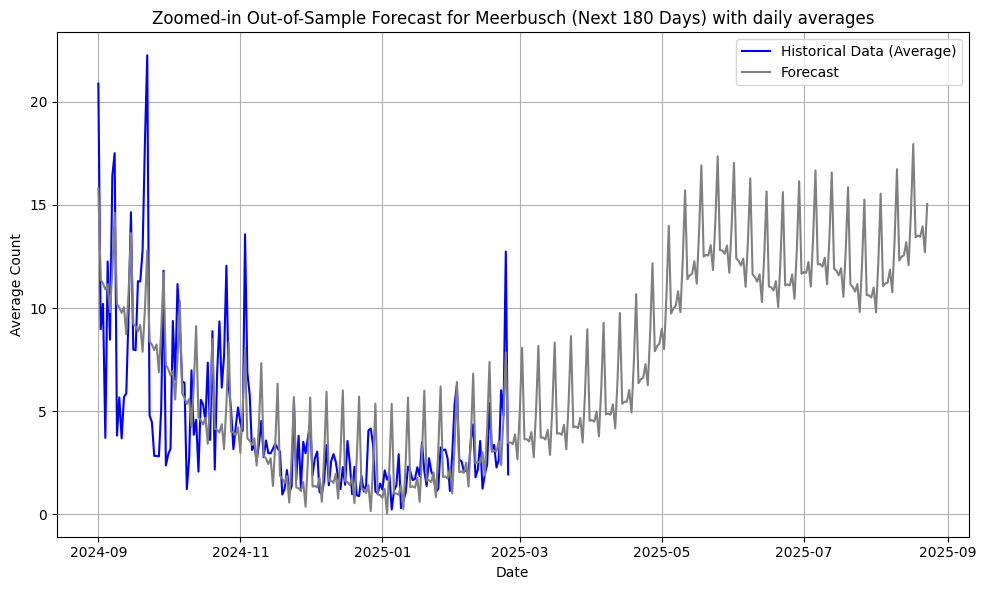

In [15]:
# Filter data to include only entries from 2024 September onwards
start_date = pd.Timestamp("2024-09-01")

# Filter historical data
historical_data = prophet_data_pandas[prophet_data_pandas["ds"] >= start_date]

# Filter forecast data
forecast_2024 = forecast[forecast["ds"] >= start_date]

# Plot future forecast 
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(historical_data["ds"], historical_data["y"], label="Historical Data (Average)", color="blue")

# Plot forecast
plt.plot(forecast_2024["ds"], forecast_2024["yhat"], label="Forecast", color="gray")

# Add labels, title, and grid
plt.title("Zoomed-in Out-of-Sample Forecast for Meerbusch (Next 180 Days) with daily averages")
plt.xlabel("Date")
plt.ylabel("Average Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 2.6.2 30 Day Prediction based on aggregated hourly count

21:26:08 - cmdstanpy - INFO - Chain [1] start processing                        
21:26:11 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Out-of-Sample Forecast for Meerbusch (Next 30 Days) with hourly averages')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Count')

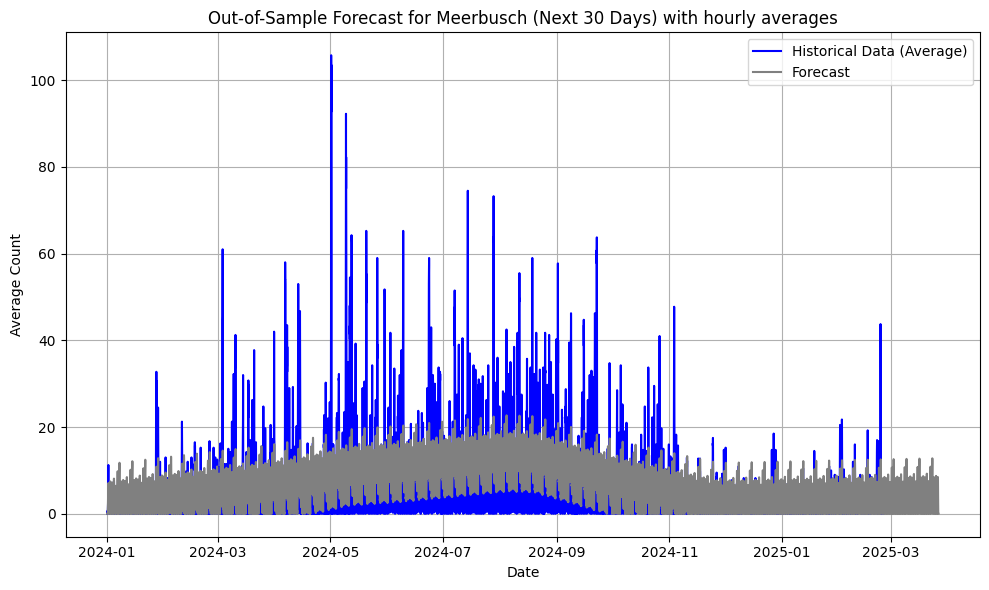

In [16]:
# Filter data for 2024 onwards and correct negative counts
df_meerbusch_filtered = (
    df_meerbusch.filter(col("Date") >= "2024-01-01")
    .withColumn("Count", when(col("Count") < 0, 0).otherwise(col("Count")))
)

# Group by Date and calculate the **average count**
aggregated_meerbusch_df = (
    df_meerbusch_filtered.groupBy("Date")
    .agg(avg("Count").alias("aggregated_count")) 
    .filter(col("aggregated_count") >= 0)  
    .orderBy("Date")
)

# Prepare data for Prophet
prophet_data = aggregated_meerbusch_df.select(
    col("Date").alias("ds"), col("aggregated_count").alias("y")
).orderBy("ds")

# Convert to Pandas
prophet_data_pandas = prophet_data.toPandas()
prophet_data_pandas["ds"] = pd.to_datetime(prophet_data_pandas["ds"])
prophet_data_pandas["y"] = pd.to_numeric(prophet_data_pandas["y"]).fillna(0)

# Train Prophet model with no negatives in the data
model = Prophet(seasonality_mode="additive")  
model.fit(prophet_data_pandas)

#  Forecast future values (ensure no negative values in the forecast)
future = model.make_future_dataframe(periods=30*24, freq='H', include_history=True)  
forecast = model.predict(future)
forecast["yhat"] = forecast["yhat"].clip(lower=0)

# Plot future forecast
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(prophet_data_pandas["ds"], prophet_data_pandas["y"], label="Historical Data (Average)", color="blue")

# Plot forecast
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="gray")

# Add labels, title, and grid
plt.title("Out-of-Sample Forecast for Meerbusch (Next 30 Days) with hourly averages")
plt.xlabel("Date")
plt.ylabel("Average Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Zoomed_ in Out-of-Sample Forecast for Meerbusch (Next 30 Days) with hourly averages')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Count')

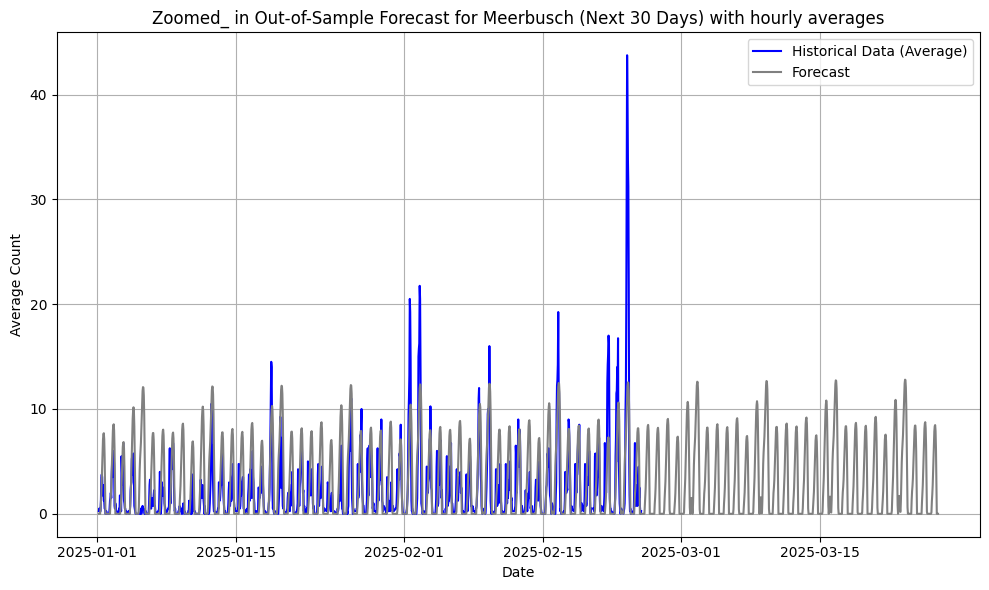

In [17]:
#  Filter data to include only entries from 2025 onwards
start_date = pd.Timestamp("2025-01-01")

# Filter historical data
historical_data_2025 = prophet_data_pandas[prophet_data_pandas["ds"] >= start_date]

# Filter forecast data
forecast_2025 = forecast[forecast["ds"] >= start_date]

# Plot future forecast (2025 onwards only)
plt.figure(figsize=(10, 6))

# Plot historical data (2025 onwards)
plt.plot(historical_data_2025["ds"], historical_data_2025["y"], label="Historical Data (Average)", color="blue")

# Plot forecast (2025 onwards)
plt.plot(forecast_2025["ds"], forecast_2025["yhat"], label="Forecast", color="grey")

# Add labels, title, and grid
plt.title("Zoomed_ in Out-of-Sample Forecast for Meerbusch (Next 30 Days) with hourly averages")
plt.xlabel("Date")
plt.ylabel("Average Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()